# Clean Metadata
This notebook processes raw metadata provided by GISAID into the format required by Augur. Furthermore, it extracts additional information into unique variables.

## Setup

### Imports

In [1]:
import glob
import numpy as np
import pandas as pd
import plotnine as p9
import re

# Custom cleaning functions
from data.prep_data.clean_seqs import clean_strain_names
from data.prep_data.clean_seqs import deduplicate

### Files

#### Inputs

In [2]:
input_gisaid_files = glob.glob('h3n2/data/raw/*asia*.xls')

#### Outputs



In [3]:
export_augur = 'h3n2/data/clean/asia_clean.tsv'

### Parameters

## Load raw data from GISAID

In [4]:
# Read each file into a dataframe
dfs = [pd.read_excel(file) for file in input_gisaid_files]

# Join all dataframes into one
meta_raw = pd.concat(dfs, ignore_index=True)
meta_raw.head()

,Isolate_Id,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id,HE Segment_Id,...,PB2 INSDC_Upload,PB1 INSDC_Upload,PA INSDC_Upload,HA INSDC_Upload,NP INSDC_Upload,NA INSDC_Upload,MP INSDC_Upload,NS INSDC_Upload,HE INSDC_Upload,P3 INSDC_Upload
0,EPI_ISL_410606,EPI1807738|2020-CX0185.1,EPI1808543|2020-CX0185.2,EPI1809337|2020-CX0185.3,EPI1691981|2020-CX0185.4,EPI1810129|2020-CX0185.5,EPI1691980|2020-CX0185.6,EPI1691979|2020-CX0185.7,EPI1810926|2020-CX0185.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_ISL_410607,EPI1807739|2020-CX0184.1,EPI1808544|2020-CX0184.2,EPI1809338|2020-CX0184.3,EPI1691984|2020-CX0184.4,EPI1810130|2020-CX0184.5,EPI1691983|2020-CX0184.6,EPI1691982|2020-CX0184.7,EPI1810927|2020-CX0184.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPI_ISL_410608,EPI1807740|2020-CX0183.1,EPI1808545|2020-CX0183.2,EPI1809339|2020-CX0183.3,EPI1691987|2020-CX0183.4,EPI1810131|2020-CX0183.5,EPI1691986|2020-CX0183.6,EPI1691985|2020-CX0183.7,EPI1810928|2020-CX0183.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPI_ISL_410609,EPI1807741|2020-CX0182.1,EPI1808546|2020-CX0182.2,EPI1809340|2020-CX0182.3,EPI1691990|2020-CX0182.4,EPI1810132|2020-CX0182.5,EPI1691989|2020-CX0182.6,EPI1691988|2020-CX0182.7,EPI1810929|2020-CX0182.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EPI_ISL_410610,EPI1807742|2020-CX0181.1,EPI1808547|2020-CX0181.2,EPI1809341|2020-CX0181.3,EPI1691993|2020-CX0181.4,EPI1810133|2020-CX0181.5,EPI1691992|2020-CX0181.6,EPI1691991|2020-CX0181.7,EPI1810930|2020-CX0181.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Keep only the columns we are interested in.

In [5]:
retained_cols = [
    'Isolate_Name',
    'Collection_Date',
    'Isolate_Id',
    'Location',
    'Host',
    'Submitting_Lab',
    'Originating_Lab']

meta_working = meta_raw[retained_cols]

Standardize column name formatting:
- all lowercase
- underscore for word separation (already true)

In [6]:
meta_working.columns = [c.lower() for c in meta_working.columns]

Provide [required columns](https://docs.nextstrain.org/projects/ncov/en/wdl-optionals/analysis/data-prep.html#required-metadata) for Nextstrain.

In [7]:
meta_working = meta_working.rename(
    columns = {
        'isolate_name': 'strain',
        'collection_date': 'date'
    }
)
meta_working['virus'] = 'h3n2_flu'

In [8]:
meta_working.head(n=20)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus
0,A/Beijing-Dongcheng/134/2020,2020-01-01,EPI_ISL_410606,Asia / China / Beijing,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu
1,A/Hebei-Zunhua/13/2020,2020-01-01,EPI_ISL_410607,Asia / China / Hebei,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu
2,A/Hubei-Wujiagang/13/2020,2020-01-02,EPI_ISL_410608,Asia / China / Hubei,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu
3,A/Hubei-Chongyang/36/2020,2020-01-01,EPI_ISL_410609,Asia / China / Hubei,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu
4,A/Liaoning-Haizhou/11/2020,2020-01-02,EPI_ISL_410610,Asia / China,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu
5,A/Qinghai-Chengzhong/14/2020,2020-01-02,EPI_ISL_410611,Asia / China / Qinghai,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu
6,A/Neimenggu-Maozhouli/15/2020,2020-01-06,EPI_ISL_410612,Asia / China / Neimenggu,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu
7,A/Shandong-Chengyang/32/2020,2020-01-02,EPI_ISL_410613,Asia / China / Shandong,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu
8,A/Sichuan-Ziliujing/16/2020,2020-01-01,EPI_ISL_410614,Asia / China / Sichuan,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu
9,A/Jilin-Longshan/12/2020,2020-01-02,EPI_ISL_410615,Asia / China / Jilin,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu


## Parse metadata

### Parse country

In [9]:
split_columns = meta_working['location'].str.split(' / ', expand=True)
meta_working['region'] = split_columns[0]
meta_working['country'] = split_columns[1]

In [10]:
meta_working.head(n=10)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus,region,country
0,A/Beijing-Dongcheng/134/2020,2020-01-01,EPI_ISL_410606,Asia / China / Beijing,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China
1,A/Hebei-Zunhua/13/2020,2020-01-01,EPI_ISL_410607,Asia / China / Hebei,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China
2,A/Hubei-Wujiagang/13/2020,2020-01-02,EPI_ISL_410608,Asia / China / Hubei,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China
3,A/Hubei-Chongyang/36/2020,2020-01-01,EPI_ISL_410609,Asia / China / Hubei,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China
4,A/Liaoning-Haizhou/11/2020,2020-01-02,EPI_ISL_410610,Asia / China,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China
5,A/Qinghai-Chengzhong/14/2020,2020-01-02,EPI_ISL_410611,Asia / China / Qinghai,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China
6,A/Neimenggu-Maozhouli/15/2020,2020-01-06,EPI_ISL_410612,Asia / China / Neimenggu,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China
7,A/Shandong-Chengyang/32/2020,2020-01-02,EPI_ISL_410613,Asia / China / Shandong,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China
8,A/Sichuan-Ziliujing/16/2020,2020-01-01,EPI_ISL_410614,Asia / China / Sichuan,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China
9,A/Jilin-Longshan/12/2020,2020-01-02,EPI_ISL_410615,Asia / China / Jilin,Human,WHO Chinese National Influenza Center,WHO Chinese National Influenza Center,h3n2_flu,Asia,China


## Clean dataframe
Clean up values.

Clean strain names
* strip leading and trailing whitespace
* replace spaces with underscores
* replace apostrophes with dashes

In [11]:
meta_working['strain'] = (
    meta_working['strain']
    .apply(lambda x: clean_strain_names(x))
)

In [12]:
meta_working.head(n=10)['strain']

0     A/Beijing-Dongcheng/134/2020
1           A/Hebei-Zunhua/13/2020
2        A/Hubei-Wujiagang/13/2020
3        A/Hubei-Chongyang/36/2020
4       A/Liaoning-Haizhou/11/2020
5     A/Qinghai-Chengzhong/14/2020
6    A/Neimenggu-Maozhouli/15/2020
7     A/Shandong-Chengyang/32/2020
8      A/Sichuan-Ziliujing/16/2020
9         A/Jilin-Longshan/12/2020
Name: strain, dtype: object

### Deduplicate strains

In [13]:
meta_working = deduplicate(meta_working, 'strain')

Originally, there were 11549 records.
	There were 10467 unique records.
	After cleaning, there were 10467 records remaining.


### Clean up countries

In [14]:
meta_working['country'].value_counts(dropna=False)

country
China                                2043
Japan                                1144
Thailand                              936
Singapore                             804
Bangladesh                            552
United Arab Emirates                  428
Korea, Republic of                    361
India                                 330
Lao, People's Democratic Republic     323
Hong Kong (SAR)                       308
Oman                                  308
Lebanon                               301
Bhutan                                217
Qatar                                 193
Malaysia                              170
Cambodia                              166
Turkey                                141
Myanmar                               131
Pakistan                              126
Philippines                           123
Bahrain                               114
Taiwan                                108
Israel                                 90
Saudi Arabia              

In [17]:
meta_working['country'] = (
    meta_working['country']
    .replace(
        {"Lao, People's Democratic Republic": 'Laos',
         'Korea, Republic of': 'South Korea',
         'Hong Kong (SAR)': 'Hong Kong',
         'Iran, Islamic Republic of': 'Iran',
         'Palestinian Territory': 'Palestine'}
    ))

In [18]:
meta_working['country'].value_counts(dropna=False)

country
China                   2043
Japan                   1144
Thailand                 936
Singapore                804
Bangladesh               552
United Arab Emirates     428
South Korea              361
India                    330
Laos                     323
Hong Kong                308
Oman                     308
Lebanon                  301
Bhutan                   217
Qatar                    193
Malaysia                 170
Cambodia                 166
Turkey                   141
Myanmar                  131
Pakistan                 126
Philippines              123
Bahrain                  114
Taiwan                   108
Israel                    90
Saudi Arabia              88
Kazakhstan                85
Indonesia                 84
Maldives                  84
Kyrgyzstan                82
Nepal                     75
Vietnam                   73
Brunei                    72
Sri Lanka                 68
Georgia                   56
Afghanistan               56
Mongol

## Export for Augur
Export tab-delimited file (TSV) for input into Augur.

- Replace `NaN` values with a question mark character (`?`), as preferred by Augur.
- Drop raw columns that have been parsed to new, expanded columns.
- Put columns in preferred order. This is not necessary for Augur, but provides a standard order for my own human reading.
- **Drop duplicate strains.**

In [19]:
col_order = [
    'strain',
    'date',
    'virus',
    'region', 
    'country',
    'host', 
    'isolate_id',
    'submitting_lab',
    'originating_lab']

meta_working = meta_working[col_order]

meta_clean = meta_working.fillna('?')

meta_clean.to_csv(export_augur, sep='\t', index=False, header=False)

## Plot and list all strains by country

### Plot strain counts by country

In [20]:
meta_clean['strain'].count()

10467

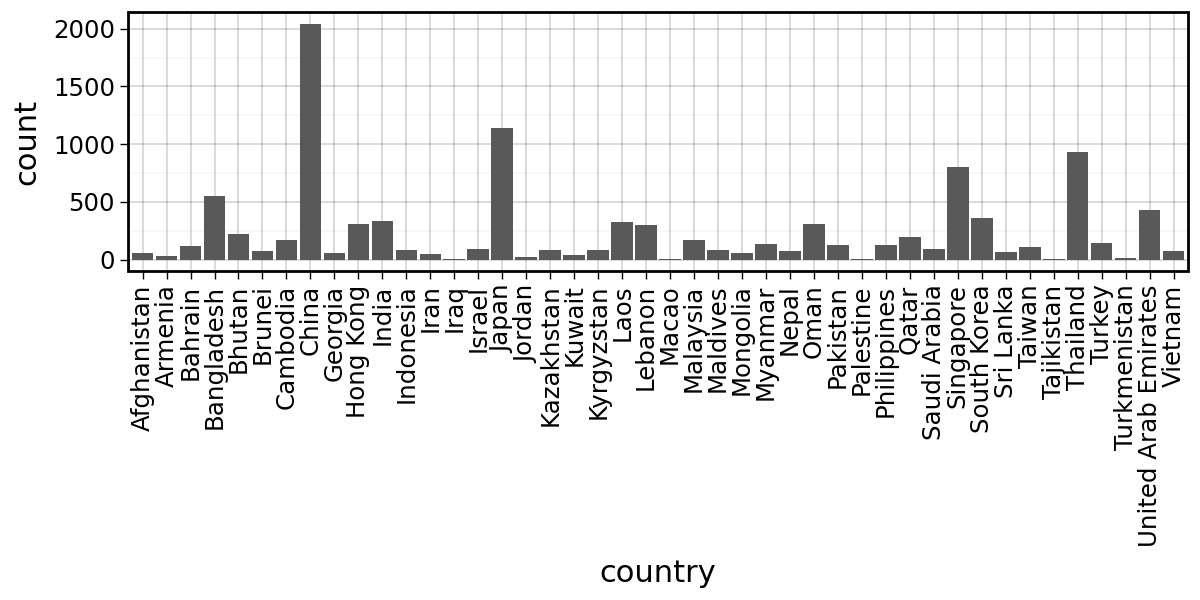

In [21]:
seqs_by_country = (
    p9.ggplot(meta_clean, p9.aes(x='country'))
    + p9.geom_bar()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(6, 3))
)

seqs_by_country


### List strains by country

In [22]:
by_country = meta_working.groupby('country')['strain'].unique()
for key, value in by_country.items():
    print(f"{key} (n={len(value)})")
    for v in value:
        print(v)

Afghanistan (n=56)
A/Afghanistan/5373/2021
A/Afghanistan/4839/2021
A/Afghanistan/5317/2021
A/Afghanistan/5022/2021
A/Afghanistan/4966/2021
A/Afghanistan/4900/2021
A/Afghanistan/4862/2021
A/Afghanistan/4961/2021
A/Afghanistan/4980/2021
A/Afghanistan/5311/2021
A/Afghanistan/4982/2021
A/Afghanistan/4819/2021
A/Afghanistan/4837/2021
A/Afghanistan/4979/2021
A/Afghanistan/4851/2021
A/Afghanistan/6100/2021
A/Afghanistan/4820/2021
A/Afghanistan/4834/2021
A/Afghanistan/5113/2021
A/Afghanistan/4903/2021
A/Afghanistan/5142/2021
A/Afghanistan/5202/2021
A/Afghanistan/5206/2021
A/Afghanistan/4960/2021
A/Afghanistan/4955/2021
A/Afghanistan/4988/2021
A/Afghanistan/5117/2021
A/Afghanistan/5301/2021
A/Afghanistan/4841/2021
A/Afghanistan/6412/2023
A/Afghanistan/5931/2023
A/Afghanistan/6262/2023
A/Afghanistan/6250/2023
A/Afghanistan/5930/2023
A/Afghanistan/5803/2023
A/Afghanistan/5687/2023
A/Afghanistan/5614/2023
A/Afghanistan/5800/2023
A/Afghanistan/5791/2023
A/Afghanistan/6257/2023
A/Afghanistan/6411/20